In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.OxfordIIITPet(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(texts_list):
    with torch.no_grad():
        label_ids = []
        text_features_cuda = []
        cls_features_cuda = []
        for label_id, texts in texts_list.items():
            label_ids.append([label_id] * len(texts))
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        text_features = torch.vstack(text_features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, text_features, text_features_cuda, cls_features_cuda, masked_similarity

In [10]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create template text features
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(template_label_texts_list)

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/pets_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [12]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'newfoundland': ['newfoundlander']
}

In [13]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_').lower()
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 1 prompts for (15)great_pyrenees
['This majestic dog is covered in thick, white fur and sports a large, fluffy tail.']

Filtered 1 prompts for (33)sphynx
['A sphinx cat is a hairless cat that looks like a mini lion.']

Filtered 1 prompts for (1)american_bulldog
['This breed is a stocky, muscular dog with a large head and a short, wide muzzle.']

Filtered 1 prompts for (2)american_pit_bull_terrier
['A medium-sized dog with a short, thick coat, muscular body, and a blocky head.']

Filtered 1 prompts for (36)yorkshire_terrier
['A typical Yorkie has long, silky black and tan fur, and a long nose.']

Filtered 1 prompts for (12)english_cocker_spaniel
['A small to medium sized dog with a long, floppy ears, and a silky coat that is often wavy or curly.']

Filtered 1 prompts for (28)saint_bernard
['A St.']

Filtered 1 prompts for (10)chihuahua
['A small, typically short-furred dog with large, pointy ears, a triangular head, and bulging eyes.']

Filtered 1 prompts for (25)pug
['It is ty

In [14]:
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create original gpt3 text features
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(filtered_gpt3_label_texts_list)

In [15]:
from collections import defaultdict

imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)

In [16]:
# Create image features
with torch.no_grad():
    img_label_ids = []
    img_features_cuda = []
    img_cls_features_cuda = []
    img_cls_name_similarity_cuda = []
    img_template_cls_similarity_cuda = []
    img_template_text_similarity_cuda = []
    img_original_gpt3_cls_similarity_cuda = []
    img_original_gpt3_text_similarity_cuda = []
    img_filtered_gpt3_cls_similarity_cuda = []
    img_filtered_gpt3_text_similarity_cuda = []
    for label_id, imgs in tqdm(imgs_grouped.items()):
        img_label_ids.append([label_id] * len(imgs))
        imgs = torch.stack([preprocess(img) for img in imgs]).to(device)
        img_embeddings = model.encode_image(imgs)
        img_embeddings /= img_embeddings.norm(dim=-1, keepdim=True)
        img_embedding = img_embeddings.mean(dim=0)
        img_embedding /= img_embedding.norm()
        img_features_cuda.append(img_embeddings)
        img_cls_features_cuda.append(img_embedding)
        # mean by cls then mul
        img_cls_name_similarity_cuda.append((img_embeddings @ cls_name_features_cuda.T).mean(dim=0))
        img_template_cls_similarity_cuda.append((img_embeddings @ template_cls_features_cuda.T).mean(dim=0))
        img_original_gpt3_cls_similarity_cuda.append((img_embeddings @ original_gpt3_cls_features_cuda.T).mean(dim=0))
        img_filtered_gpt3_cls_similarity_cuda.append((img_embeddings @ filtered_gpt3_cls_features_cuda.T).mean(dim=0))
        # mul then mean by cls
        img_template_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in template_text_features_cuda]))
        img_original_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in original_gpt3_text_features_cuda]))
        img_filtered_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in filtered_gpt3_text_features_cuda]))
    img_label_ids = np.hstack(img_label_ids)
    img_features_cuda = torch.vstack(img_features_cuda)
    img_features = img_features_cuda.cpu().numpy()
    img_cls_features_cuda = torch.vstack(img_cls_features_cuda)
    # mean by cls then mul
    img_cls_name_similarity = torch.vstack(img_cls_name_similarity_cuda).cpu().numpy()
    img_template_cls_similarity = torch.vstack(img_template_cls_similarity_cuda).cpu().numpy()
    img_original_gpt3_cls_similarity = torch.vstack(img_original_gpt3_cls_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_cls_similarity = torch.vstack(img_filtered_gpt3_cls_similarity_cuda).cpu().numpy()
    # mul then mean by cls
    img_template_text_similarity = torch.vstack(img_template_text_similarity_cuda).cpu().numpy()
    img_original_gpt3_text_similarity = torch.vstack(img_original_gpt3_text_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_text_similarity = torch.vstack(img_filtered_gpt3_text_similarity_cuda).cpu().numpy()

    # Fill diagonal for better visibility
    img_masked_similarity = (img_cls_features_cuda @ img_cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

100%|██████████| 37/37 [00:33<00:00,  1.09it/s]


In [17]:
# Zero-shot classification using CLIP
with torch.no_grad():
    logits_cls_name_cuda = img_features_cuda @ cls_name_features_cuda.T
    logits_template_cls_cuda = img_features_cuda @ template_cls_features_cuda.T
    logits_original_gpt3_cls_cuda = img_features_cuda @ original_gpt3_cls_features_cuda.T
    logits_filtered_gpt3_cls_cuda = img_features_cuda @ filtered_gpt3_cls_features_cuda.T

    pred_cls_name = logits_cls_name_cuda.argmax(dim=-1).cpu().numpy()
    pred_template_cls = logits_template_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_original_gpt3_cls = logits_original_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_filtered_gpt3_cls = logits_filtered_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()

    correct_cls_name = (pred_cls_name == img_label_ids).mean()
    correct_template_cls = (pred_template_cls == img_label_ids).mean()
    correct_original_gpt3 = (pred_original_gpt3_cls == img_label_ids).mean()
    correct_filtered_gpt3 = (pred_filtered_gpt3_cls == img_label_ids).mean()

In [18]:
print(f'Accuracy of CLIP with class names: {correct_cls_name*100:.2f}%')
print(f'Accuracy of CLIP with text template: {correct_template_cls*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text: {correct_original_gpt3*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text: {correct_filtered_gpt3*100:.2f}%')

Accuracy of CLIP with class names: 80.10%
Accuracy of CLIP with text template: 87.05%
Accuracy of CLIP with original GPT-3 text: 91.11%
Accuracy of CLIP with filtered GPT-3 text: 91.01%


In [19]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}')

In [20]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [21]:
def visualize_auto_similarity(masked_similarity, title):
    print(f'{title.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_similarity(np.triu(masked_similarity, k=1))
    plot_similarity(masked_similarity, title)

In [22]:
def visualize_cross_similarity(similarity, title, xlabel='Text', ylabel='Image'):
    print(f'{title.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_similarity(similarity, top=20)
    plot_similarity(similarity, title, xlabel=xlabel, ylabel=ylabel)

Class name similarity mean: 0.56396484375
Class name similarity std: 0.0948486328125
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.8955078125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.82568359375
Rank 3: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.818359375
Rank 4: (10)chihuahua - (24)pomeranian, Similarity: 0.79931640625
Rank 5: (3)basset_hound - (4)beagle, Similarity: 0.79150390625
Rank 6: (6)birman - (26)ragdoll, Similarity: 0.78173828125
Rank 7: (7)bombay - (23)persian, Similarity: 0.78076171875
Rank 8: (24)pomeranian - (25)pug, Similarity: 0.77392578125
Rank 9: (5)bengal - (7)bombay, Similarity: 0.77294921875
Rank 10: (26)ragdoll - (32)siamese, Similarity: 0.76708984375


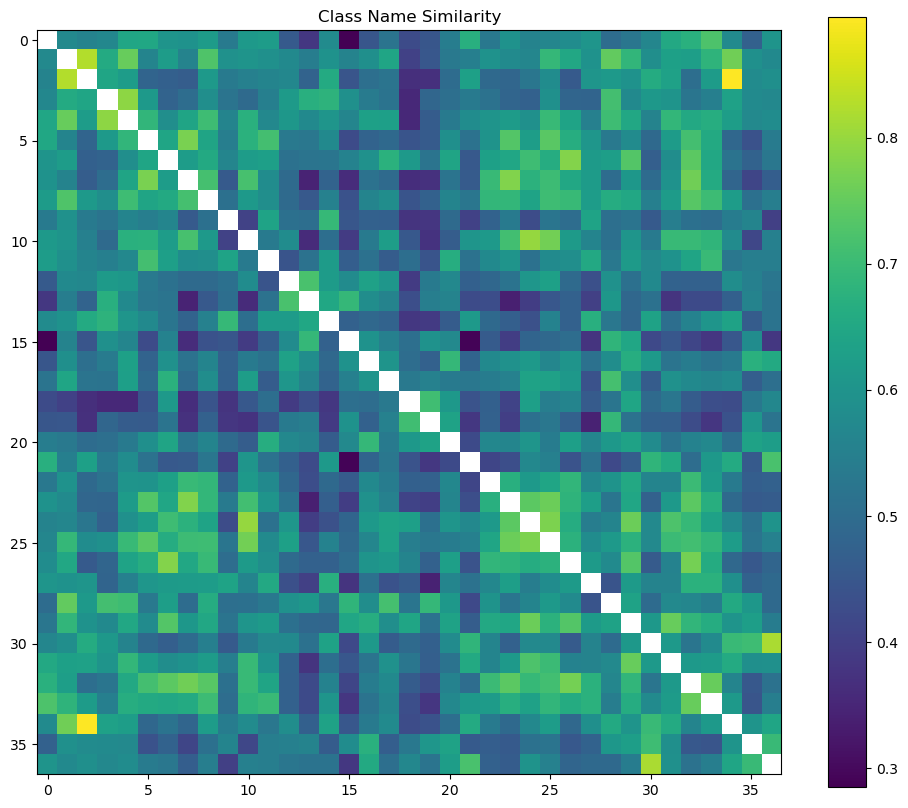

Text template similarity mean: 0.58056640625
Text template similarity std: 0.0989990234375
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.9013671875
Rank 2: (10)chihuahua - (24)pomeranian, Similarity: 0.8251953125
Rank 3: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.82177734375
Rank 4: (6)birman - (26)ragdoll, Similarity: 0.818359375
Rank 5: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81787109375
Rank 6: (3)basset_hound - (4)beagle, Similarity: 0.81689453125
Rank 7: (24)pomeranian - (29)samoyed, Similarity: 0.79345703125
Rank 8: (7)bombay - (23)persian, Similarity: 0.79345703125
Rank 9: (1)american_bulldog - (8)boxer, Similarity: 0.79345703125
Rank 10: (6)birman - (32)siamese, Similarity: 0.7890625


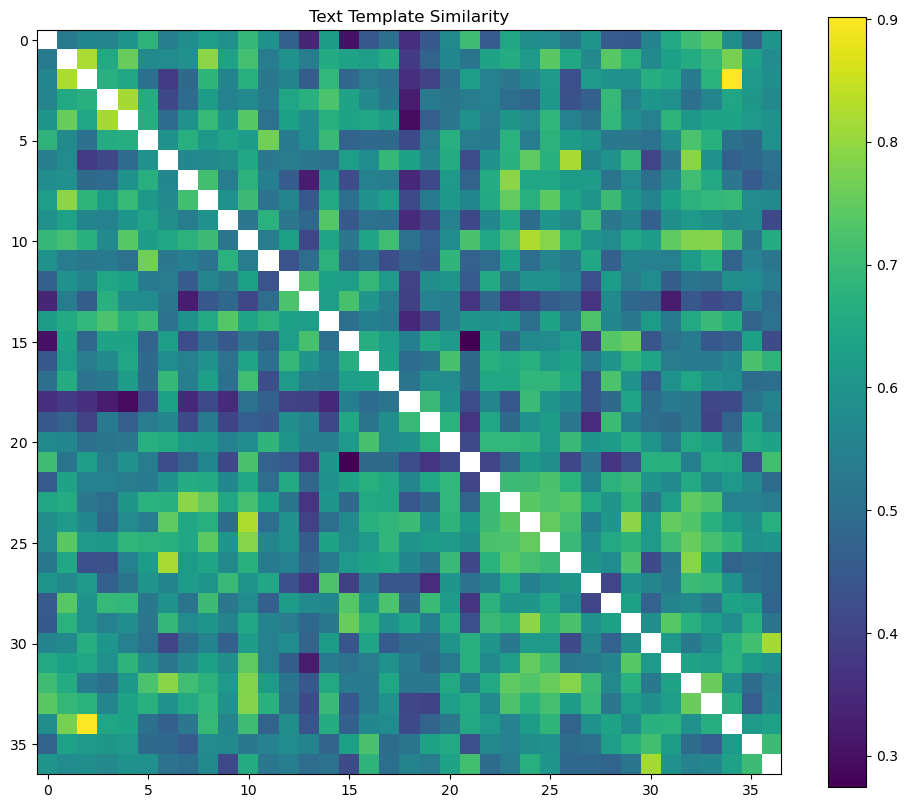

Original gpt-3 text similarity mean: 0.6181640625
Original gpt-3 text similarity std: 0.09503173828125
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.93017578125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.90283203125
Rank 3: (15)great_pyrenees - (29)samoyed, Similarity: 0.8681640625
Rank 4: (6)birman - (26)ragdoll, Similarity: 0.861328125
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, Similarity: 0.8564453125
Rank 6: (2)american_pit_bull_terrier - (8)boxer, Similarity: 0.85205078125
Rank 7: (1)american_bulldog - (8)boxer, Similarity: 0.84716796875
Rank 8: (10)chihuahua - (24)pomeranian, Similarity: 0.8408203125
Rank 9: (3)basset_hound - (4)beagle, Similarity: 0.83740234375
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81591796875


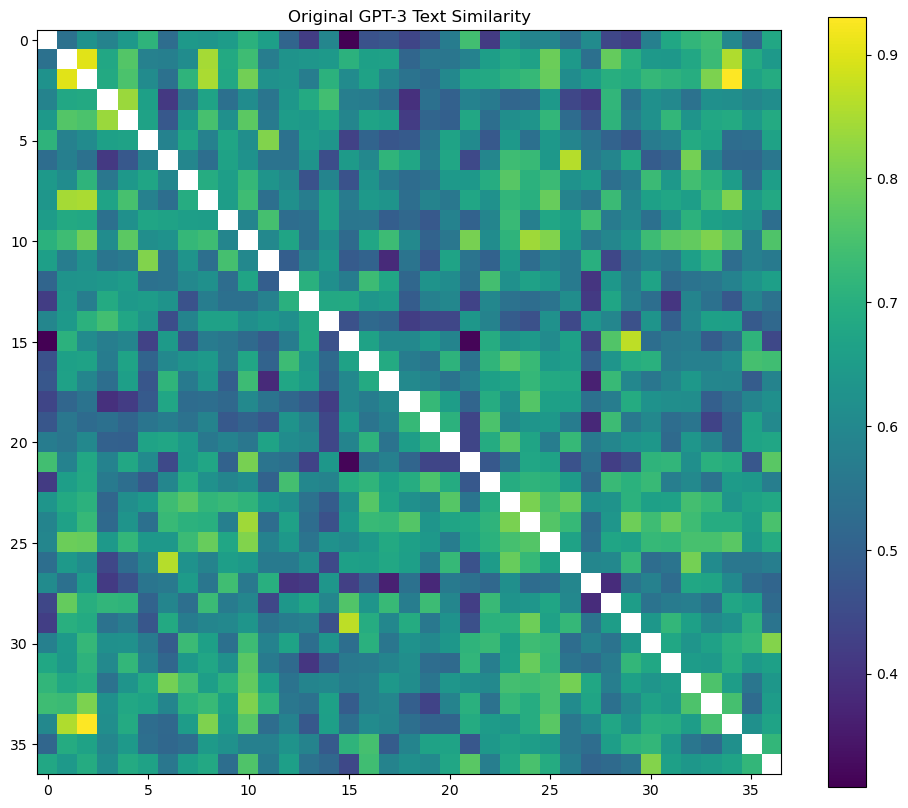

Filtered gpt-3 text similarity mean: 0.61279296875
Filtered gpt-3 text similarity std: 0.09564208984375
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.9306640625
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.8955078125
Rank 3: (6)birman - (26)ragdoll, Similarity: 0.861328125
Rank 4: (15)great_pyrenees - (29)samoyed, Similarity: 0.85791015625
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, Similarity: 0.85107421875
Rank 6: (2)american_pit_bull_terrier - (8)boxer, Similarity: 0.84765625
Rank 7: (1)american_bulldog - (8)boxer, Similarity: 0.84130859375
Rank 8: (3)basset_hound - (4)beagle, Similarity: 0.83740234375
Rank 9: (10)chihuahua - (24)pomeranian, Similarity: 0.83642578125
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81640625


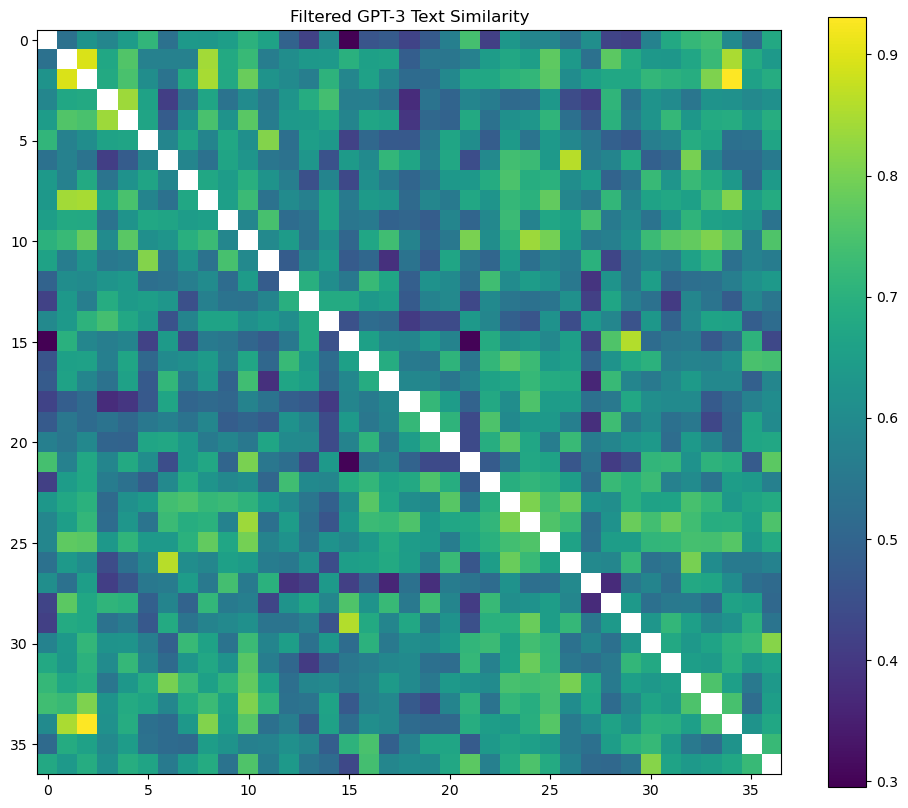

In [23]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name Similarity')
visualize_auto_similarity(template_masked_similarity, 'Text Template Similarity')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text Similarity')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text Similarity')

Image similarity mean: 0.87841796875
Image similarity std: 0.048126220703125
Rank 1: (6)birman - (26)ragdoll, Similarity: 0.98779296875
Rank 2: (12)english_cocker_spaniel - (13)english_setter, Similarity: 0.9794921875
Rank 3: (6)birman - (32)siamese, Similarity: 0.97705078125
Rank 4: (1)american_bulldog - (8)boxer, Similarity: 0.9765625
Rank 5: (9)british_shorthair - (27)russian_blue, Similarity: 0.9755859375
Rank 6: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.97509765625
Rank 7: (5)bengal - (11)egyptian_mau, Similarity: 0.9736328125
Rank 8: (10)chihuahua - (21)miniature_pinscher, Similarity: 0.9736328125
Rank 9: (19)leonberger - (22)newfoundland, Similarity: 0.97314453125
Rank 10: (16)havanese - (36)yorkshire_terrier, Similarity: 0.97314453125


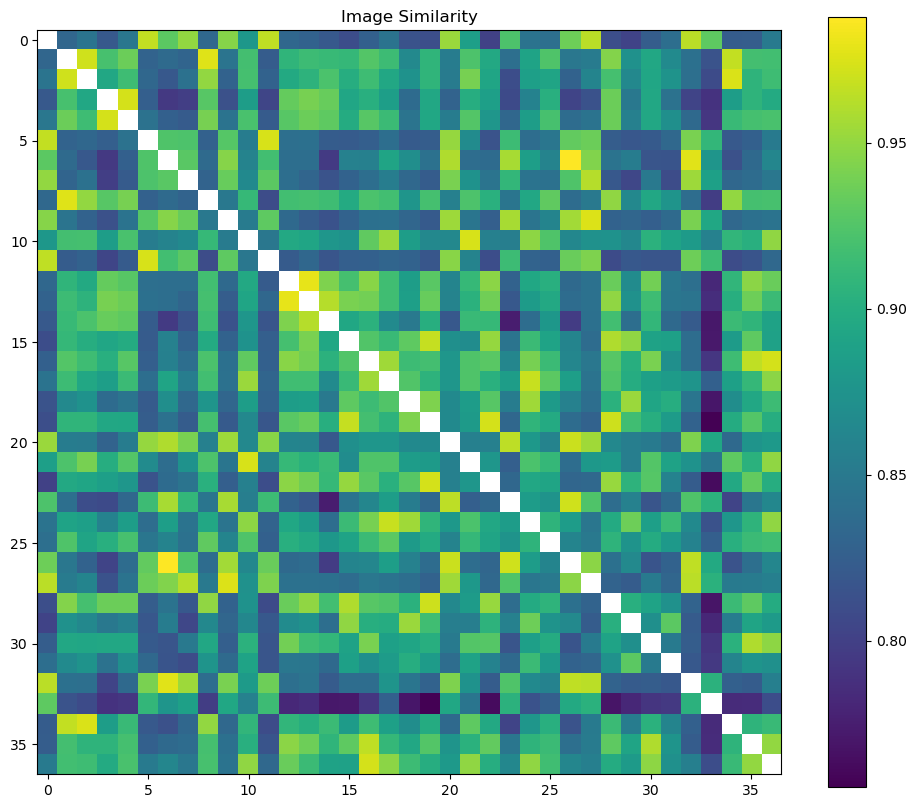

Image to class name similarity mean: 0.203369140625
Image to class name similarity std: 0.0391845703125
Image to class name similarity diagonal mean: 0.307861328125
Image to class name similarity diagonal std: 0.0240936279296875
Image to class name similarity non-diagonal mean: 0.200439453125
Image to class name similarity non-diagonal std: 0.035369873046875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5361328125
Rank 1: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.34423828125
Rank 2: (18)keeshond - (18)keeshond, Similarity: 0.341552734375
Rank 3: (19)leonberger - (19)leonberger, Similarity: 0.33251953125
Rank 4: (9)british_shorthair - (9)british_shorthair, Similarity: 0.330810546875
Rank 5: (0)abyssinian - (0)abyssinian, Similarity: 0.330810546875
Rank 6: (17)japanese_chin - (17)japanese_chin, Similarity: 0.330078125
Rank 7: (14)german_shorthaired - (14)german_shorthaired, Similarity: 0.324951171875
Rank 8: (3)basset_hound - (3)basset_hound,

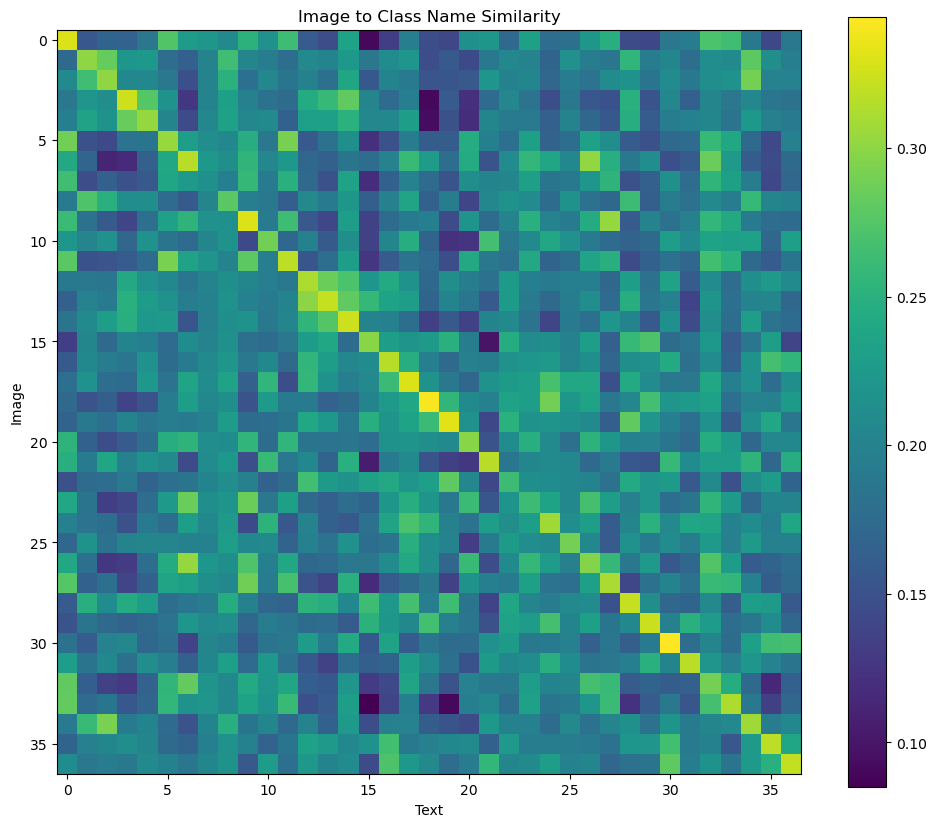

Image to text template similarity mean: 0.2137451171875
Image to text template similarity std: 0.044219970703125
Image to text template similarity diagonal mean: 0.33154296875
Image to text template similarity diagonal std: 0.02081298828125
Image to text template similarity non-diagonal mean: 0.21044921875
Image to text template similarity non-diagonal std: 0.040008544921875
Image to text template similarity diagonal mean to non-diagonal mean ratio: 1.5751953125
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.360107421875
Rank 2: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.359619140625
Rank 3: (0)abyssinian - (0)abyssinian, Similarity: 0.356201171875
Rank 4: (19)leonberger - (19)leonberger, Similarity: 0.349609375
Rank 5: (9)british_shorthair - (9)british_shorthair, Similarity: 0.34912109375
Rank 6: (6)birman - (6)birman, Similarity: 0.34814453125
Rank 7: (17)japanese_chin - (17)japanese_chin, Similarity: 0.346923828125
Rank 8: (31)shiba_inu - (31)shiba_inu, Similarit

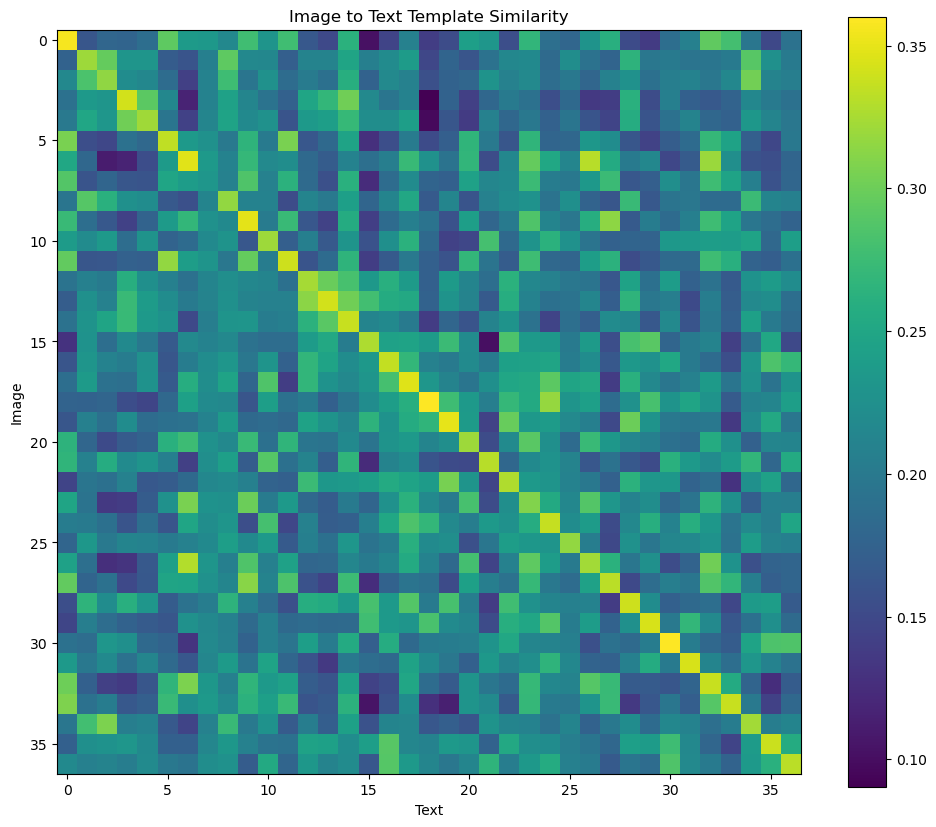

Image to text template similarity (individual) mean: 0.1942533254623413
Image to text template similarity (individual) std: 0.03992689773440361
Image to text template similarity (individual) diagonal mean: 0.30158624053001404
Image to text template similarity (individual) diagonal std: 0.019928060472011566
Image to text template similarity (individual) non-diagonal mean: 0.1912718564271927
Image to text template similarity (individual) non-diagonal std: 0.036034829914569855
Image to text template similarity (individual) diagonal mean to non-diagonal mean ratio: 1.576741337776184
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.332275390625
Rank 2: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.33056640625
Rank 3: (19)leonberger - (19)leonberger, Similarity: 0.321533203125
Rank 4: (0)abyssinian - (0)abyssinian, Similarity: 0.319091796875
Rank 5: (6)birman - (6)birman, Similarity: 0.31640625
Rank 6: (13)english_setter - (13)english_setter, Similarity: 0.31591796875
Rank 7: 

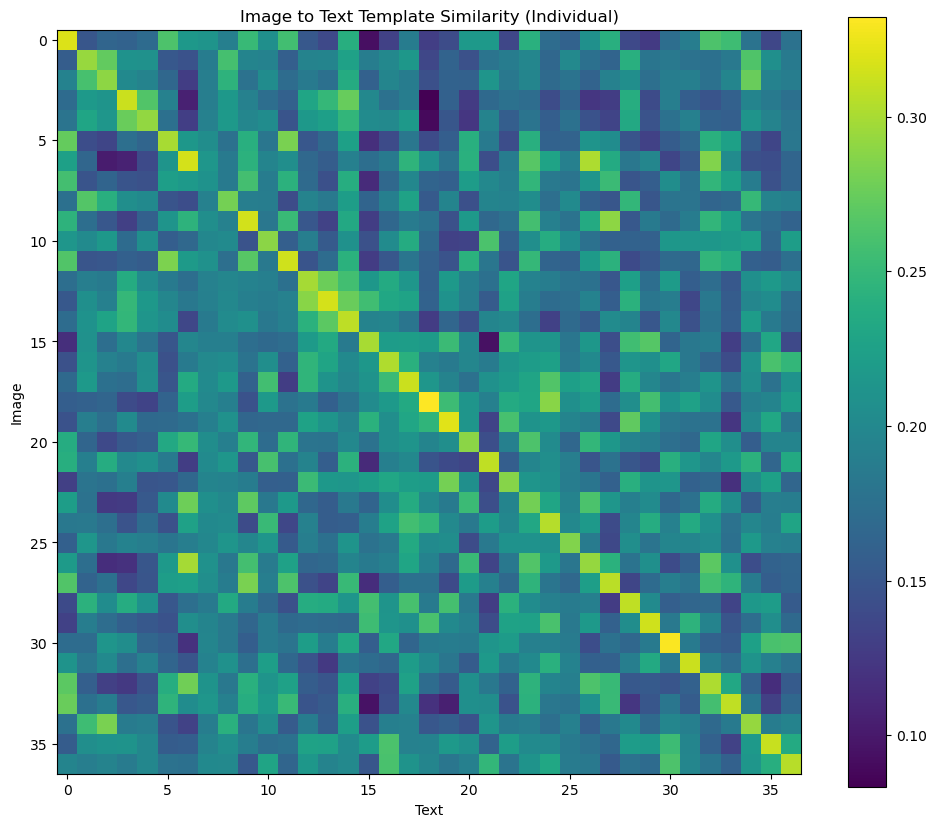

Image to original gpt-3 text similarity mean: 0.218994140625
Image to original gpt-3 text similarity std: 0.045501708984375
Image to original gpt-3 text similarity diagonal mean: 0.34130859375
Image to original gpt-3 text similarity diagonal std: 0.0110931396484375
Image to original gpt-3 text similarity non-diagonal mean: 0.2156982421875
Image to original gpt-3 text similarity non-diagonal std: 0.04119873046875
Image to original gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.58203125
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.3662109375
Rank 2: (22)newfoundland - (22)newfoundland, Similarity: 0.359130859375
Rank 3: (3)basset_hound - (3)basset_hound, Similarity: 0.358642578125
Rank 4: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.354736328125
Rank 5: (29)samoyed - (29)samoyed, Similarity: 0.353515625
Rank 6: (19)leonberger - (19)leonberger, Similarity: 0.352783203125
Rank 7: (0)abyssinian - (0)abyssinian, Similarity: 0.3515625
Rank 8: (28)saint_b

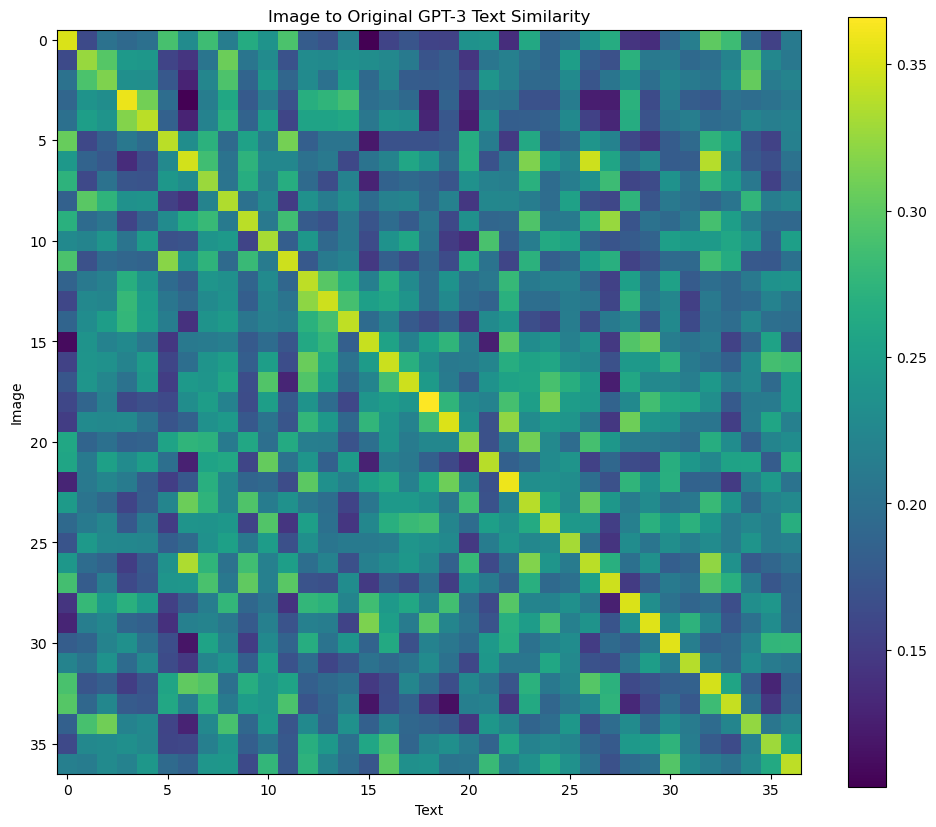

Image to original gpt-3 text similarity (individual) mean: 0.21151557564735413
Image to original gpt-3 text similarity (individual) std: 0.04370562359690666
Image to original gpt-3 text similarity (individual) diagonal mean: 0.32976141571998596
Image to original gpt-3 text similarity (individual) diagonal std: 0.0109843285754323
Image to original gpt-3 text similarity (individual) non-diagonal mean: 0.20823097229003906
Image to original gpt-3 text similarity (individual) non-diagonal std: 0.03950583189725876
Image to original gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.5836329460144043
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.3505859375
Rank 2: (3)basset_hound - (3)basset_hound, Similarity: 0.3505859375
Rank 3: (19)leonberger - (19)leonberger, Similarity: 0.345703125
Rank 4: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.343017578125
Rank 5: (22)newfoundland - (22)newfoundland, Similarity: 0.34130859375
Rank 6: (13)english_setter

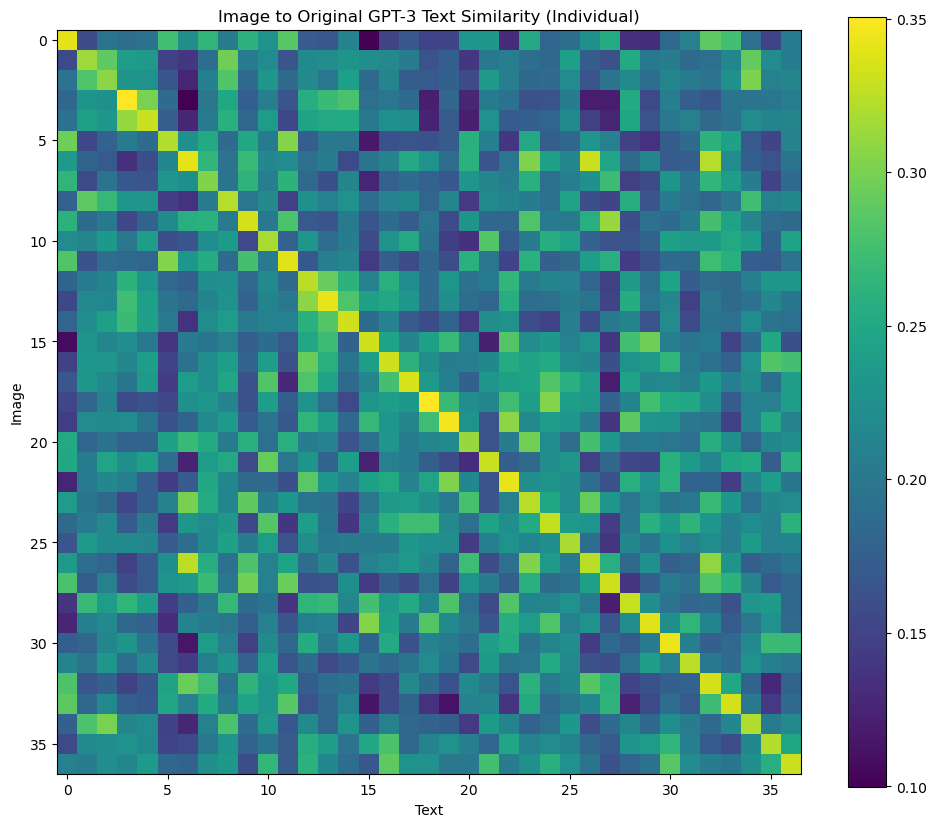

Image to filtered gpt-3 text similarity mean: 0.217529296875
Image to filtered gpt-3 text similarity std: 0.045623779296875
Image to filtered gpt-3 text similarity diagonal mean: 0.340576171875
Image to filtered gpt-3 text similarity diagonal std: 0.0108489990234375
Image to filtered gpt-3 text similarity non-diagonal mean: 0.214111328125
Image to filtered gpt-3 text similarity non-diagonal std: 0.041259765625
Image to filtered gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.5908203125
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.36181640625
Rank 2: (22)newfoundland - (22)newfoundland, Similarity: 0.359130859375
Rank 3: (3)basset_hound - (3)basset_hound, Similarity: 0.358642578125
Rank 4: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.354736328125
Rank 5: (19)leonberger - (19)leonberger, Similarity: 0.352783203125
Rank 6: (0)abyssinian - (0)abyssinian, Similarity: 0.3515625
Rank 7: (28)saint_bernard - (28)saint_bernard, Similarity: 0.349853515625
Ran

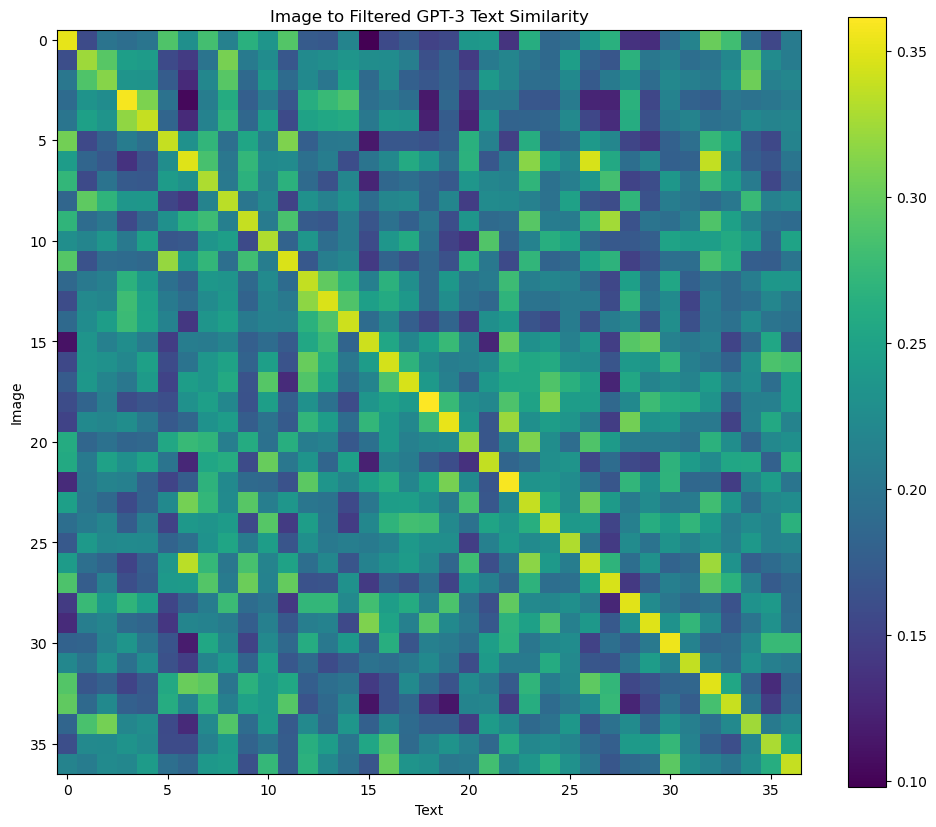

Image to filtered gpt-3 text similarity (individual) mean: 0.21109674870967865
Image to filtered gpt-3 text similarity (individual) std: 0.04406270384788513
Image to filtered gpt-3 text similarity (individual) diagonal mean: 0.3305729925632477
Image to filtered gpt-3 text similarity (individual) diagonal std: 0.010484532453119755
Image to filtered gpt-3 text similarity (individual) non-diagonal mean: 0.2077779620885849
Image to filtered gpt-3 text similarity (individual) non-diagonal std: 0.0398104153573513
Image to filtered gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.5909916162490845
Rank 1: (18)keeshond - (18)keeshond, Similarity: 0.354736328125
Rank 2: (3)basset_hound - (3)basset_hound, Similarity: 0.3505859375
Rank 3: (19)leonberger - (19)leonberger, Similarity: 0.345703125
Rank 4: (30)scottish_terrier - (30)scottish_terrier, Similarity: 0.343017578125
Rank 5: (22)newfoundland - (22)newfoundland, Similarity: 0.34130859375
Rank 6: (29)samoyed - (29

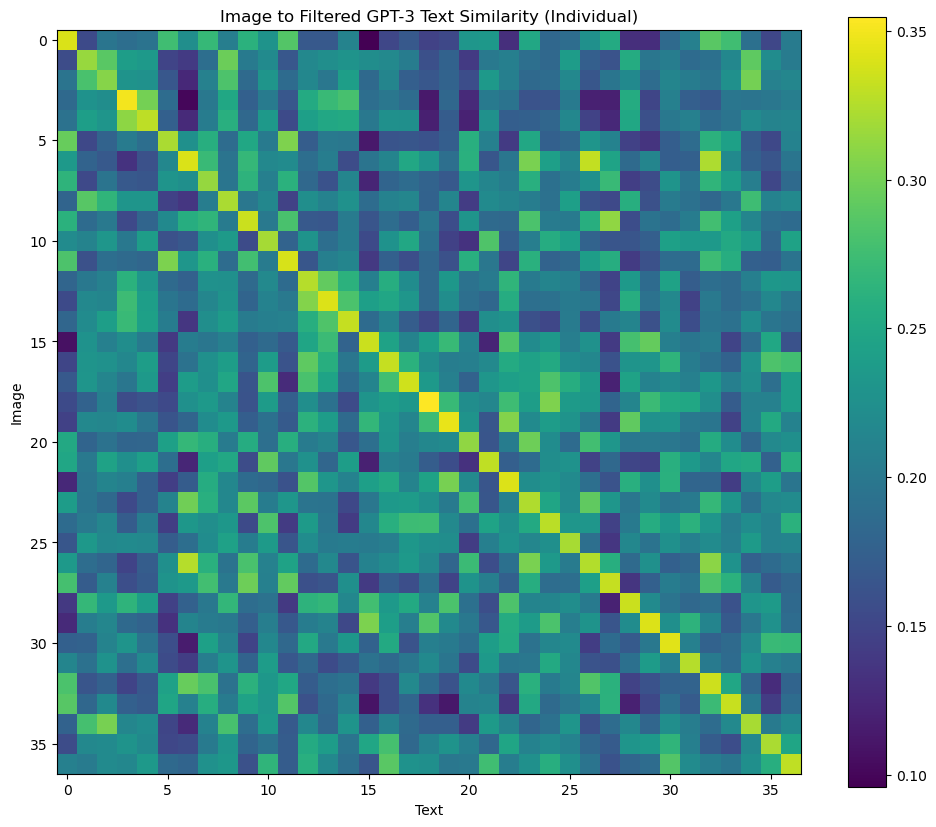

In [24]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image Similarity')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, 'Image to Class Name Similarity')
visualize_cross_similarity(img_template_cls_similarity, 'Image to Text Template Similarity')
visualize_cross_similarity(img_template_text_similarity, 'Image to Text Template Similarity (Individual)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, 'Image to Original GPT-3 Text Similarity')
visualize_cross_similarity(img_original_gpt3_text_similarity, 'Image to Original GPT-3 Text Similarity (Individual)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, 'Image to Filtered GPT-3 Text Similarity')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, 'Image to Filtered GPT-3 Text Similarity (Individual)')

In [25]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [26]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [27]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.8955078125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.82568359375
Rank 3: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.818359375
Rank 4: (10)chihuahua - (24)pomeranian, Similarity: 0.79931640625
Rank 5: (3)basset_hound - (4)beagle, Similarity: 0.79150390625
Rank 6: (6)birman - (26)ragdoll, Similarity: 0.78173828125
Rank 7: (7)bombay - (23)persian, Similarity: 0.78076171875
Rank 8: (24)pomeranian - (25)pug, Similarity: 0.77392578125
Rank 9: (5)bengal - (7)bombay, Similarity: 0.77294921875
Rank 10: (26)ragdoll - (32)siamese, Similarity: 0.76708984375


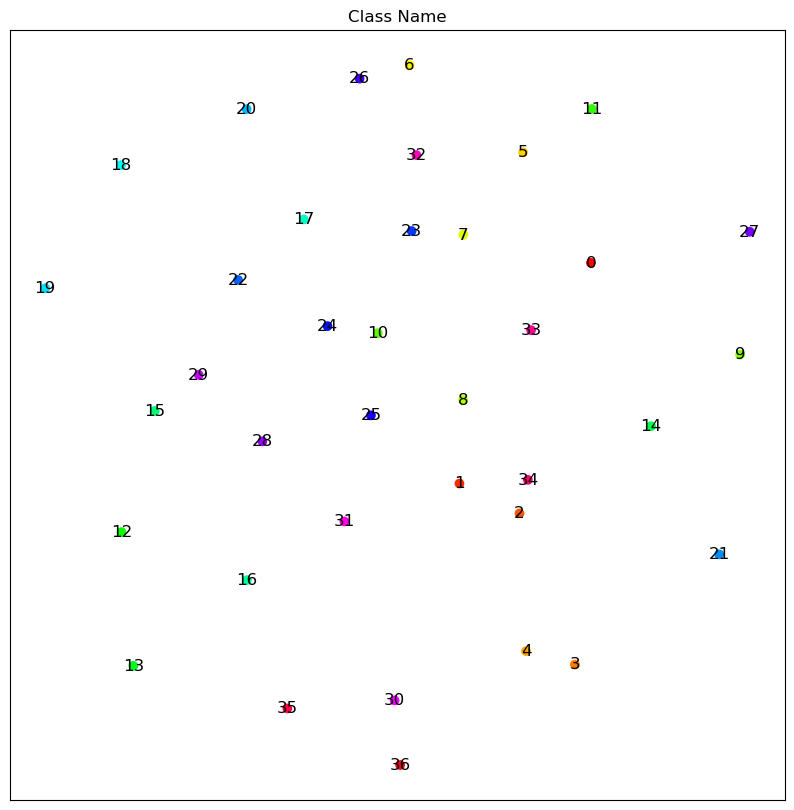

Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.9013671875
Rank 2: (10)chihuahua - (24)pomeranian, Similarity: 0.8251953125
Rank 3: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.82177734375
Rank 4: (6)birman - (26)ragdoll, Similarity: 0.818359375
Rank 5: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81787109375
Rank 6: (3)basset_hound - (4)beagle, Similarity: 0.81689453125
Rank 7: (24)pomeranian - (29)samoyed, Similarity: 0.79345703125
Rank 8: (7)bombay - (23)persian, Similarity: 0.79345703125
Rank 9: (1)american_bulldog - (8)boxer, Similarity: 0.79345703125
Rank 10: (6)birman - (32)siamese, Similarity: 0.7890625


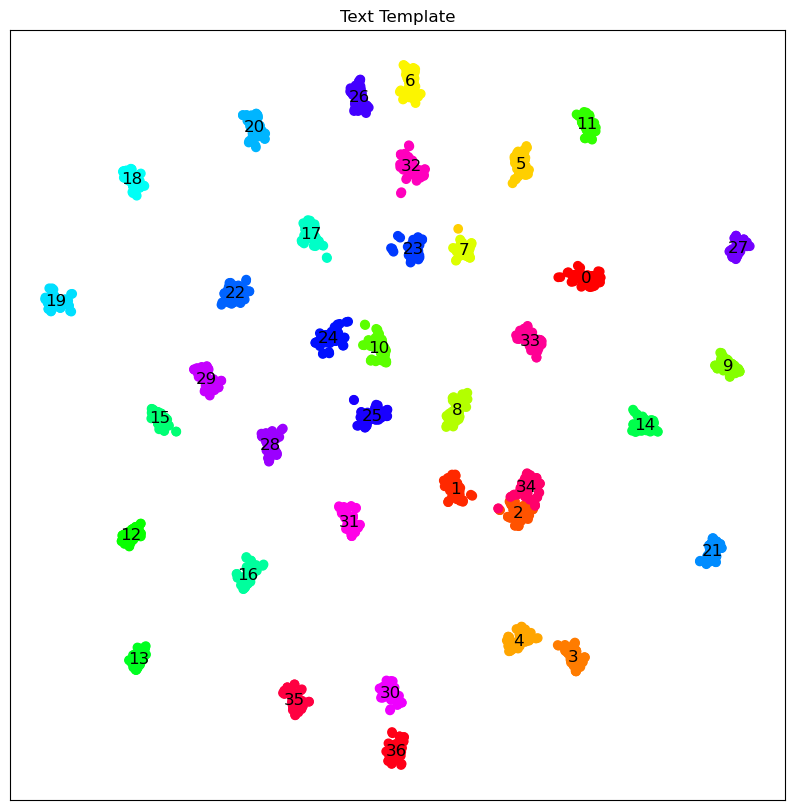

Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.93017578125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.90283203125
Rank 3: (15)great_pyrenees - (29)samoyed, Similarity: 0.8681640625
Rank 4: (6)birman - (26)ragdoll, Similarity: 0.861328125
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, Similarity: 0.8564453125
Rank 6: (2)american_pit_bull_terrier - (8)boxer, Similarity: 0.85205078125
Rank 7: (1)american_bulldog - (8)boxer, Similarity: 0.84716796875
Rank 8: (10)chihuahua - (24)pomeranian, Similarity: 0.8408203125
Rank 9: (3)basset_hound - (4)beagle, Similarity: 0.83740234375
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81591796875


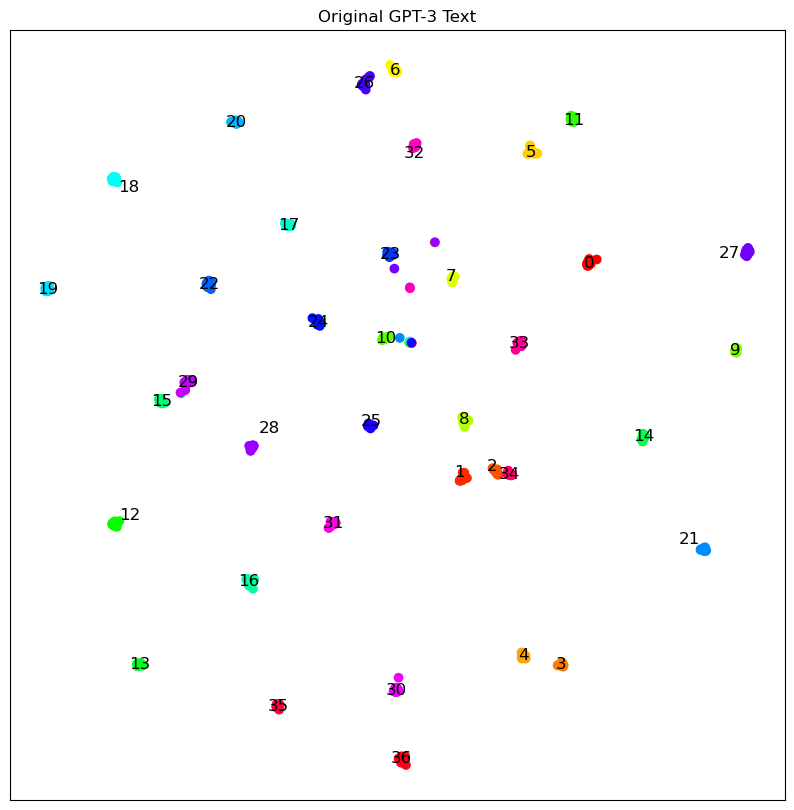

Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, Similarity: 0.9306640625
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, Similarity: 0.8955078125
Rank 3: (6)birman - (26)ragdoll, Similarity: 0.861328125
Rank 4: (15)great_pyrenees - (29)samoyed, Similarity: 0.85791015625
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, Similarity: 0.85107421875
Rank 6: (2)american_pit_bull_terrier - (8)boxer, Similarity: 0.84765625
Rank 7: (1)american_bulldog - (8)boxer, Similarity: 0.84130859375
Rank 8: (3)basset_hound - (4)beagle, Similarity: 0.83740234375
Rank 9: (10)chihuahua - (24)pomeranian, Similarity: 0.83642578125
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, Similarity: 0.81640625


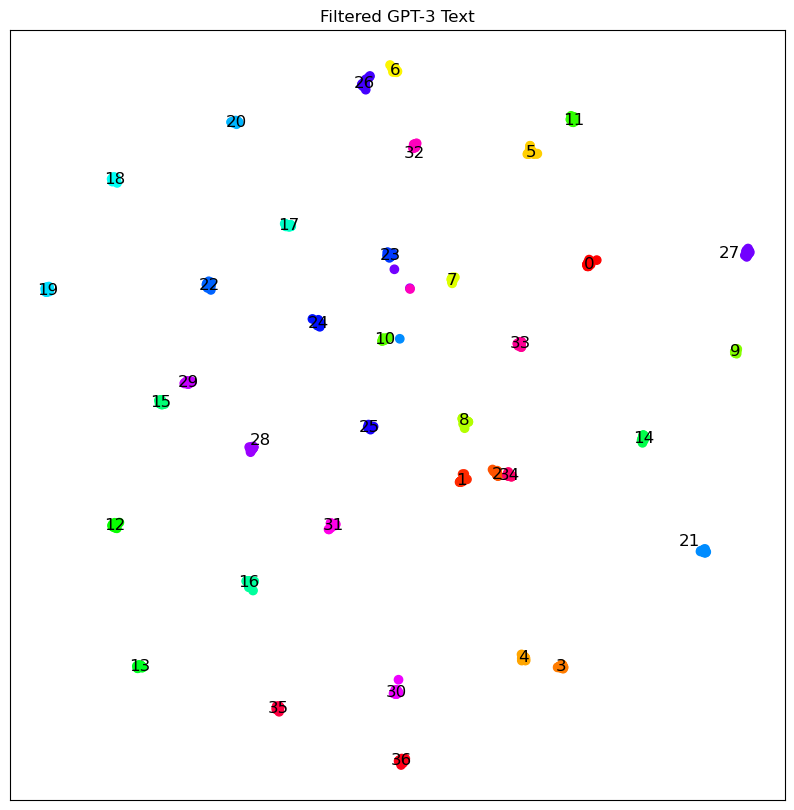

In [28]:
print_top_similarity(np.triu(cls_name_masked_similarity, k=1))
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_similarity(np.triu(template_masked_similarity, k=1))
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_similarity(np.triu(original_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_similarity(np.triu(filtered_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')